In [ ]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, box
import matplotlib.pyplot as plt

In [ ]:
#!/usr/bin/env python3

import sys
from pathlib import Path
import pandas as pd
from nltk import edit_distance

import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets

# Add src to path for imports
# sys.path.insert(0, str(Path(__file__).parent))

from src.models import ModelManager, load_word2vec_model
from src.analogy_tests import (
    run_analogy_test_suite,
    print_test_summary,
    test_analogy,
    explore_nearest_neighbors,
    calculate_vector_arithmetic
)
manager = ModelManager()
model = manager.load_word2vec_google_news()

Loading Word2Vec Google News model...
Model: word2vec-google-news-300
Size: ~1.6GB download, ~3.5GB in memory
This may take a few minutes on first download...
✓ Model loaded successfully!
  Vocabulary size: 3,000,000 words
  Vector dimensions: 300


In [84]:
def analogy_calc(lis):
    try:
        res_li = []
        for li in lis:
            try:
                word1, word2, word3, target1, target2 = li
                positive = [word2, word3]
                negative = [word1]
                res = calculate_vector_arithmetic(model, positive, negative, topn=1000)
                
                res = pd.DataFrame(res, columns=['word', 'similarity'])

                res['word'] = res['word'].str.lower()

                res['edit_distance_target1'] = res['word'].apply(lambda el: edit_distance(el, target1.lower()))
                res['edit_distance_target2'] = res['word'].apply(lambda el: edit_distance(el, target2.lower()))
                # print(res)
                target1_similarity = res[res['edit_distance_target1'] <= 1].set_index('word')['similarity'].max()
                target2_similarity = res[res['edit_distance_target2'] <= 1].set_index('word')['similarity'].max()
                res_li.append({
                    'list': li,
                    target1 : target1_similarity,
                    target2 : target2_similarity
                })
            except Exception:
                continue
        return res_li
        
    except Exception as e:
        print(f"\nError: {e}")
        import traceback
        traceback.print_exc()
        return 1

In [78]:
import requests
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time

# Step 1: Download table from Wikipedia (with user-agent)
url = "https://en.wikipedia.org/wiki/List_of_settlements_on_the_island_of_Ireland_by_population"
headers = {"User-Agent": "Mozilla/5.0 (compatible; IrishTownsMapper/1.0; +https://example.com/contact)"}
r = requests.get(url, headers=headers)
r.raise_for_status()

# Step 2: Read table and take top 50
tables = pd.read_html(r.text)
df = tables[0].head(50)

# Clean up column names (optional)
df.columns = [c.strip() for c in df.columns]

# Step 3: Set up geocoder
geolocator = Nominatim(user_agent="IrishTownsMapper/1.0")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)  # be polite!

# Step 4: Get lat/long for each town
lats, longs = [], []

for place in df["Settlement"]:
    try:
        location = geocode(f"{place}, Ireland")
        if location is None:
            location = geocode(f"{place}, Northern Ireland")
        if location:
            lats.append(location.latitude)
            longs.append(location.longitude)
        else:
            lats.append(None)
            longs.append(None)
    except Exception as e:
        print(f"Error geocoding {place}: {e}")
        lats.append(None)
        longs.append(None)
    time.sleep(1)  # extra delay for safety

df["Latitude"] = lats
df["Longitude"] = longs

# Step 5: Save to CSV
df.to_csv("top50_irish_towns_with_coords.csv", index=False)
print("Saved top50_irish_towns_with_coords.csv ✅")


/var/folders/_7/lk3y5njx2yq4v1pgz41w3wcw0000gn/T/ipykernel_79467/3747931106.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(r.text)


KeyboardInterrupt: 

In [79]:
df = pd.read_csv("top50_irish_towns_with_coords.csv")

In [80]:
df = df[['Settlement', 'Jurisdiction', 'Latitude', 'Longitude']]

In [81]:
df

,Settlement,Jurisdiction,Latitude,Longitude
0,Dublin,Republic,53.349379,-6.260559
1,Belfast,Northern,54.597580,-5.927710
2,Cork,Republic,51.898514,-8.472642
3,Limerick,Republic,52.661252,-8.630124
4,Galway,Republic,53.274412,-9.049060
5,Derry,Northern,53.400846,-7.251987
6,Newtownabbey,Northern,54.677882,-5.924920
7,Bangor,Northern,54.154855,-9.721193
8,Waterford,Republic,52.261000,-7.111908
9,Lisburn,Northern,53.403256,-8.324792


In [85]:
input_for_analogy_calc = [['Lyon', 'French', el, 'Irish', 'British'] for el in df['Settlement']]

res = pd.DataFrame(analogy_calc(input_for_analogy_calc))

res['Settlement'] = res['list'].map(lambda e: e[2])

res = pd.merge(df, res, on='Settlement')
res.head()

Error: Word not found in vocabulary: "Key 'Greystones-Delgany' not present in vocabulary"
Error: Word not found in vocabulary: "Key 'Laytown–Bettystown–Mornington–Donacarney' not present in vocabulary"


,Settlement,Jurisdiction,Latitude,Longitude,list,Irish,British
0,Dublin,Republic,53.349379,-6.260559,"[Lyon, French, Dublin, Irish, British]",0.655825,0.512567
1,Belfast,Northern,54.597580,-5.927710,"[Lyon, French, Belfast, Irish, British]",0.575745,0.568508
2,Cork,Republic,51.898514,-8.472642,"[Lyon, French, Cork, Irish, British]",0.637087,0.465244
3,Limerick,Republic,52.661252,-8.630124,"[Lyon, French, Limerick, Irish, British]",0.635086,0.413726
4,Galway,Republic,53.274412,-9.049060,"[Lyon, French, Galway, Irish, British]",0.632031,0.427482


In [88]:
res = res.dropna()

In [91]:
abs_diffs = np.abs(res['Irish'] - res['British'])
std = np.std(abs_diffs)

res['irishness'] = (res['Irish'] - res['British']) / std

/var/folders/_7/lk3y5njx2yq4v1pgz41w3wcw0000gn/T/ipykernel_79467/3197792348.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['irishness'] = (res['Irish'] - res['British']) / std


In [100]:
gadm_uk = gpd.read_file("https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_GBR_shp.zip")
gadm_ie = gpd.read_file("https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_IRL_shp.zip")

british_isles = gpd.GeoDataFrame(pd.concat([gadm_uk, gadm_ie], ignore_index=True))

# Clip to bounding box (for clean extent)
bounds = box(-11, 49.5, -5, 60)
british_isles = british_isles.clip(bounds)

/Users/daxmavy/oxford/fsds25-analogy/venv/lib/python3.13/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'gadm41_GBR_shp.zip': 'gadm41_GBR_0' (default), 'gadm41_GBR_1', 'gadm41_GBR_2', 'gadm41_GBR_3', 'gadm41_GBR_4'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/daxmavy/oxford/fsds25-analogy/venv/lib/python3.13/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'gadm41_IRL_shp.zip': 'gadm41_IRL_0' (default), 'gadm41_IRL_1', 'gadm41_IRL_2'. Specify layer parameter to avoid this warning.
  result = read_func(


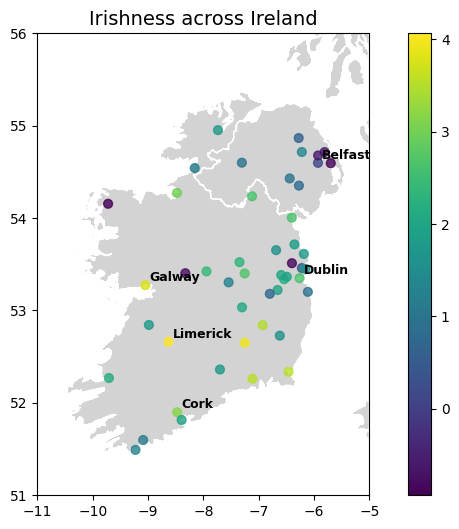

In [ ]:
# Create geometry from coordinates
geometry = [Point(xy) for xy in zip(res['Longitude'], res['Latitude'])]
gdf = gpd.GeoDataFrame(res, geometry=geometry, crs="EPSG:4326")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
british_isles.plot(ax=ax, color="lightgrey", edgecolor="white")

# Points colored by 'irishness'
gdf.plot(
    ax=ax,
    column="irishness",
    cmap="viridis",
    legend=True,
    markersize=40,
    alpha=0.8
)

ax.set_xlim([-11, -5])
ax.set_ylim([51, 56])
ax.set_title("Irishness across Ireland", fontsize=14)

# --- Annotate top 5 towns ---
for i, row in gdf.head(5).iterrows():
    ax.annotate(
        text=row["Settlement"],         # column containing town name
        xy=(row["Longitude"], row["Latitude"]),
        xytext=(3, 3),                  # small offset in points
        textcoords="offset points",
        fontsize=9,
        fontweight="bold",
        color="black"
        path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=2, foreground="white")]
    )

plt.show()


In [96]:
res[res['Jurisdiction'] == 'Republic'].sort_values('irishness', ascending=True)

,Settlement,Jurisdiction,Latitude,Longitude,list,Irish,British,irishness
48,Ashbourne,Republic,53.511615,-6.398174,"[Lyon, French, Ashbourne, Irish, British]",0.415465,0.461091,-0.838266
12,Swords,Republic,53.459480,-6.219175,"[Lyon, French, Swords, Irish, British]",0.399129,0.372270,0.493470
27,Newbridge,Republic,53.180149,-6.798193,"[Lyon, French, Newbridge, Irish, British]",0.424077,0.385234,0.713669
14,Bray,Republic,53.201460,-6.110505,"[Lyon, French, Bray, Irish, British]",0.440763,0.387724,0.974477
40,Malahide,Republic,53.450840,-6.153670,"[Lyon, French, Malahide, Irish, British]",0.542021,0.454585,1.606447
13,Navan,Republic,53.653094,-6.684043,"[Lyon, French, Navan, Irish, British]",0.504583,0.416595,1.616603
32,Letterkenny,Republic,54.951794,-7.735437,"[Lyon, French, Letterkenny, Irish, British]",0.519191,0.424348,1.742540
41,Clonmel,Republic,52.361082,-7.699124,"[Lyon, French, Clonmel, Irish, British]",0.503197,0.408087,1.747440
19,Ennis,Republic,52.843515,-8.983747,"[Lyon, French, Ennis, Irish, British]",0.516870,0.421676,1.748983
28,Balbriggan,Republic,53.611877,-6.182328,"[Lyon, French, Balbriggan, Irish, British]",0.525657,0.430212,1.753598


In [72]:
df

,Rank,Settlement,Population,Province,County,Jurisdiction,Description,Latitude,Longitude
0,1,Dublin,"592,713[3]",Leinster,County Dublin,Republic,Capital city of the Republic of Ireland. Large...,53.349379,-6.260559
1,2,Belfast,348005,Ulster,"County Antrim, County Down",Northern,Capital of Northern Ireland and largest city i...,54.597580,-5.927710
2,3,Cork,222333,Munster,County Cork,Republic,Largest city in the province of Munster in the...,51.898514,-8.472642
3,4,Limerick,102287,Munster,"County Limerick, County Clare",Republic,Principal city of Ireland's Mid-West Region an...,52.661252,-8.630124
4,5,Galway,85910,Connacht,County Galway,Republic,Largest city in the province of Connacht,53.274412,-9.049060
5,6,Derry,85279,Ulster,County Londonderry,Northern,Second largest city in Ulster,53.400846,-7.251987
6,7,Newtownabbey,67599,Ulster,County Antrim,Northern,Part of the Belfast Metropolitan Area. It was ...,54.677882,-5.924920
7,8,Bangor,64596,Ulster,County Down,Northern,Granted city status in 2022. Though a city in ...,54.154855,-9.721193
8,9,Waterford,60079,Munster,"County Waterford, County Kilkenny",Republic,Third-largest in the province of Munster. It i...,52.261000,-7.111908
9,10,Lisburn,51447,Ulster,"County Antrim, County Down",Northern,Granted city status in 2002. The city lies on ...,53.403256,-8.324792
